In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm

In addition to the ```numpy``` and ```matplotlib``` packages, this example requires the ```emcee``` and ```corner``` packages. ```emcee``` is a 'stand alone' package, while ```corner``` is included in ```astropy```. All of them can be easily installed from the conda framework. 

In [2]:
import emcee
import corner

# Surface brightness fit

In this example we will fit a surface brightness $I(R)$ profile through a MCMC approach. The profile was sampled from a Plummer model assuming a total mass $M=10^5\,[M_{\odot}]$, a scale radius $a=2\,[\text{pc}]$ and a constant mass-to-light ratio $\Upsilon_0 = 1.5\,[M_{\odot}/L_{\odot}]$. The advantage of using a Plummer model is that we can easily obtain the analytical form of the surface brightness.

The Plummer model follows a mass density profile as:

\begin{equation*}
\rho(r) = \frac{3M}{4\pi a^3}\frac{1}{(1+r^2/a^2)^{5/2}}
\quad\quad\text{(1)}
\end{equation*}

assuming the mass-to-light ratio $\Upsilon_0 = 1.5\,[M_{\odot}/L_{\odot}]$, the surface brigthness is 

\begin{equation*}
I(R) = \frac{I_0}{(1+R^2/a^2)^{2}}
\quad\quad\text{(2)}
\end{equation*}

where $I_0 = M/(\pi a^2\Upsilon_0)$.

In this case the model will only require the last part of the surface brightness profile defined within the Jeans code:

\begin{equation*}
I(R) = I_{0}\times(R/a_1)^{-s_0}\times(1+(R/a_1)^{\alpha_1})^{-s_1/\alpha_1}\times(1+(R/a_2)^{\alpha_2})^{-s_2/\alpha_2}
\quad\quad\text{(3)}
\end{equation*}

we will fit for only $I_0$, $a_2$, $s_2$ and $\alpha_2$, and ignore the other parameters. For the given Plummer model, the expected values for the parameters are:

$I_0 = 5305.16\,[L_{\odot}\text{pc}^{-2}]$

$a_2 = 2\,[\text{pc}]$

$s_2 = 4$

$\alpha_2 = 2$

## [1] Data

For this example we will use the following mock data, that includes the projected radius $R$ in $[\text{pc}]$, the surface luminosity $L$ in $L_{\odot}/\text{pc}^2$ and the error in the surface luminosity.

In [3]:
## DATA
R,L,dL = np.loadtxt('LUMN_PRF.txt',unpack=True)

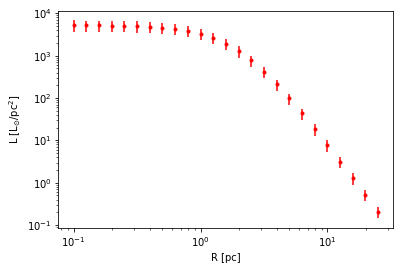

In [4]:
plt.errorbar(R,L,dL,fmt='.r')

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'R [pc]')
plt.ylabel(r'L [L$_{\odot}$/pc$^2$]')

plt.show()

## [2] FIT 

The ```emcee``` package is a sampler for the Markov-Chain Monte Carlo (MCMC) method. The general idea is to generate random walkers that explore the parameter space, in each step of the chain it evaluates the likelihood function for a given set of values in the paarmeter space and moves to another point in the parameter space. This movement is not fully random, as it depends on an internal probability to move or stay in place. As the walker moves searching for the maximun likelihood, this approach allows it to escape from local maxima. The example here follows the introduction for the ```emcee``` code availabe in [emcee: fitting a model to data](https://emcee.readthedocs.io/en/stable/tutorials/line/), I recommend to check the webpage of ```emcee``` for a better description of the code. Also, to have a better understanding of the bayesian approach, the likelihood function and MCMC technique (and python in general), the blog of [Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) is really useful. 


As ```emcee``` is a sampler, it requires to define some functions before hand: our model (```lum_prof```), the loglikelihood function (```lum_lnlike```), the prior distribution (```lum_lnprior```) and the total probability (```lum_lnprob```) which is a combination of the prior probability and the likelihood. 

In this case we are not using the complete cuspy double power-law for the luminosity profile, the parameter space is reduced to only 4 parameters: $I_0$, $a_2$, $s_2$ and $\alpha_2$ (the other 4 parameters are fixed).  

We also assume Gaussian errors so the loglikelihood function is:

\begin{equation*}
\ln \text{L}(\theta|L,R) = \sum_{i} \frac{(L_{i}-I(R_{i},\theta))^2}{\Delta L_{i}^2}
\quad\quad\text{(4)}
\end{equation*}

where $R_i$, $L_i$ and $\Delta L_i$ are the projected radius, the surface brightness and the error in surface brightness from the observed data. $I(R,\theta)$ is our model with parameters $\theta$. We define this into the function ```lum_lnlike```. 


The prior distribution for the parameters is flat, so all values between the defined regions in ```lum_lnprior``` have the same probability. Values outside the region are excluded by giving them a probability of $p=-\infty$.

Finally the ```lum_lnprob``` function combines the loglikelihood and the prior probability. If the parameter falls outside or range the total probability is $p=-\infty$, if fall inside the range the probability will be one from the likelihood.

In [5]:
################################################################################
################################################################################
###  MCMC FITTING METHODS VIA EMCEE

def lum_prof(R,pars):
    I0, a2, s2, alph_2 = pars
    a1, s0, s1, alph_1 = 1.0, 0.0, 0.0, 1.0
    return I0*(R/a1)**(-s0)*(1.+(R/a1)**alph_1)**(-s1/alph_1)*(1.+(R/a2)**alph_2)**(-s2/alph_2)

def lum_lnlike(theta, x, y, yerr):
    logI0, a2, s2, alph_2 = theta
    model      = lum_prof(x,[10**logI0, a2, s2, alph_2])
    inv_sigma2 = 1.0/yerr**2
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

def lum_lnprior(theta):
    logI0, a2, s2, alph_2 = theta
    if 1. <= logI0 <= 6. and 0.1 <= a2 <= 20.0 and 0.0 <= s2 <= 10.0 and 1.0 <= alph_2 <= 10.0:
        return 0.0
    return -np.inf

def lum_lnprob(theta, x, y, yerr):
    lp = lum_lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lum_lnlike(theta, x, y, yerr)


To run the MCMC we need to generate a ```sampler``` object using the ```emcee.EnsambleSampler``` function. This functions requires as input the number of walkers (```n_walkers```), numbers of parameters (or dimension ```n_dim```) the total probability function (```lum_lnprob```) and the data as arguments.

The sampler starts by usin ```sampler.run_mcmc```, which requires an initial position for each walker (```init_pos```) and the length of the chain (i.e how many steps we want to do, ```n_chain```)

In [6]:
n_dim, n_walkers, n_chain = 4, 100, 50000

init_guess = np.array([3.0,3.0,1.0,2.0])
init_pos    = [init_guess + 1e-2*np.random.randn(n_dim) for i in range(n_walkers)]

t0 = tm.time()
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lum_lnprob, args=(R,L,0.5*dL))
sampler.run_mcmc(init_pos, n_chain)

t1 = tm.time()

print('Done in %lf sec'%(t1-t0))

Done in 140.587909 sec


Before going to the results it is useful to observe the different chains and how the logLikelihood evolves on each chain, in that way we can see if the walkers converge to a value (also to see if some parameters are useless). This also allows us to define a ```n_burn``` value. We 'burn' (or exclude) all values before ```n_burn```, and just keep the sampled values that have converged. In the plots below we select the values after the red dashed line. 

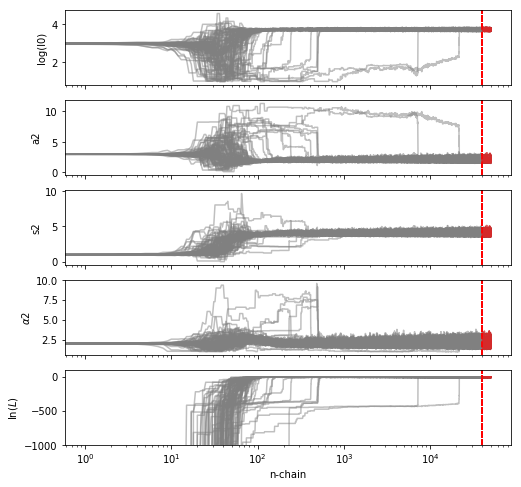

In [7]:
fig, axs = plt.subplots(n_dim+1,1,figsize=(8,8),sharex=True)

###############################################
labels = [r'log(I0)',r'a2',r's2',r'$\alpha$2']
n_burn = 40000
###############################################

#Parameters
for k in range(n_dim):
    for j in range(n_walkers):
        axs[k].plot(np.arange(n_chain)[:],sampler.chain[j,:,k],'-',c='0.5',alpha=0.5)
        axs[k].axvline(x=n_burn,ls='--',c='r')
        axs[k].plot(np.arange(n_chain)[n_burn:],sampler.chain[j,n_burn:,k],'-',c='r',alpha=0.5)
        axs[k].set_ylabel(labels[k])

#Likelihood
for j in range(n_walkers):
    axs[-1].plot(np.arange(n_chain)[:],(sampler.lnprobability[j,:]),'-',c='0.5',alpha=0.5)
    axs[-1].axvline(x=n_burn,ls='--',c='r')
    axs[-1].plot(np.arange(n_chain)[n_burn:],(sampler.lnprobability[j,n_burn:]),'-',c='r',alpha=0.5)
axs[-1].set_ylabel(r'$\ln(L)$')
axs[-1].set_ylim([-1e3,+1e2])
#
axs[-1].set_xscale('log')
axs[-1].set_xlabel('n-chain')
plt.show()

Although unlikely, some walkers could fail and still fall in local maxima. This chains could have a significantly lower logLikelihood. Using the plots above one also could put a tolerance value for the logLikelihood and only select those that converge to the global maxima.

In [8]:
### Penalize chains 
p_chain   = []
lnL_limit = -10 

for k in range(n_walkers):
    if sampler.lnprobability[k,-1] < lnL_limit:
        p_chain.append(False)
    else: 
        p_chain.append(True)


## [3] Results

Now we can extract the samples from the chains that have converged and satisfy our 'burn' selection. The following step select the samples and join all chains into one array.

In [9]:
###################################################################
samples = sampler.chain[p_chain, n_burn:, :].reshape((-1, n_dim))
loglike = sampler.lnprobability[p_chain,n_burn:].reshape(-1)


###################################################################

We can observe also that the maximun likelihood parameters and the median of the posterior distribution of parameters are consistent with the expected (Real) values. 

In [10]:
print('Pars  | MaxL | Median | Real')
print('----------------------------')
print('logI0 | %4.2lf |  %4.2lf  | 3.72'%(samples[np.argmax(loglike),0],np.median(samples[:,0])))
print('   a2 | %4.2lf |  %4.2lf  | 2.00'%(samples[np.argmax(loglike),1],np.median(samples[:,1])))
print('   s2 | %4.2lf |  %4.2lf  | 4.00'%(samples[np.argmax(loglike),2],np.median(samples[:,2])))
print('alph2 | %4.2lf |  %4.2lf  | 2.00'%(samples[np.argmax(loglike),3],np.median(samples[:,3])))

Pars  | MaxL | Median | Real
----------------------------
logI0 | 3.72 |  3.72  | 3.72
   a2 | 2.00 |  2.00  | 2.00
   s2 | 4.00 |  4.00  | 4.00
alph2 | 1.97 |  1.97  | 2.00


A useful tool to observe the results from our fit is the corner plot from ```corner``` as shown below. This also help us to see if there is any correlation between the parameters, as is the case here for $a_2$ and $s_2$. 

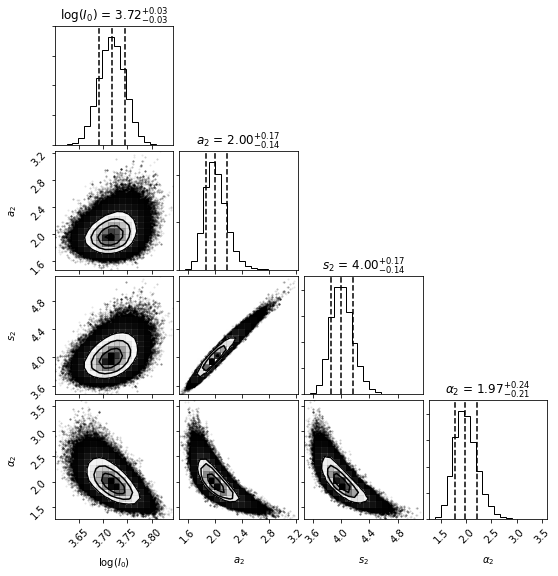

In [14]:
fig,axs = plt.subplots(4,4,figsize=(8,8))

corner.corner(samples,labels=[r'$\log(I_0)$',r'$a_2$',r'$s_2$',r'$\alpha_2$'],
                        quantiles=[0.16, 0.5, 0.84],show_titles=True,fig=fig)
fig.savefig('bla.pdf',bbox_inches='tight')

Finally we can how the models fit the data, in the next plot I have selected randomly 1000 sets of paramters and plotted the model given those parameters as gray lines. All of them follows the data, which is great.

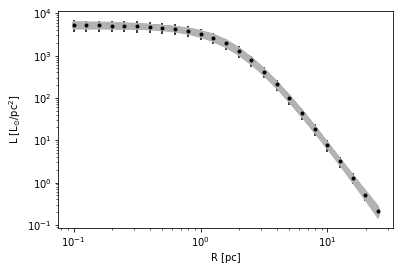

In [52]:
for k in np.random.choice(np.arange(samples.shape[0]),size=1000,replace=False):
    logI0, a2, s2, alph2 = samples[k]
    
    plt.plot(R,lum_prof(R,[10**logI0,a2,s2,alph2]),'-',c='0.7',alpha=0.5)

plt.errorbar(R,L,dL,fmt='.k')

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'R [pc]')
plt.ylabel(r'L [L$_{\odot}$/pc$^2$]')

plt.show()